In [1]:
# --- Standard Library ---
import os
import sys
import random
import yaml

# --- Third-Party Libraries ---
import numpy as np
import torch
from tqdm import tqdm
import SimpleITK as sitk
from matplotlib import pyplot as plt
from termcolor import colored
from accelerate import Accelerator

project_root = '/d/hpc/projects/FRI/jf73497/aimi-project/src/segformer3duls/'
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    

from dataloaders.build_dataset import build_dataset, build_dataloader
from architectures.build_architecture import build_architecture
from metrics.competition_metric import ULS23_evaluator

/d/hpc/projects/FRI/jf73497/aimi-project/src/segformer3duls/venv_segformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_data_path = "/d/hpc/home/jf73497/projects/aimi-project-data/raw/Dataset001_MIX"

image_path = test_data_path + "/imagesTs/MIX_06966_0000.nii.gz"
label_path = test_data_path + "/labelsTs/MIX_06966.nii.gz"

# Read image slice (single slice)
image_itk = sitk.ReadImage(image_path)
image = sitk.GetArrayFromImage(image_itk).astype(np.float32)

# Read full label volume
label_itk = sitk.ReadImage(label_path)
label = sitk.GetArrayFromImage(label_itk).astype(np.int64)

In [ ]:
class NiiSliceDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform

        # List all image slices
        self.image_paths = sorted(glob(os.path.join(images_dir, "MIX_*_*.nii.gz")))
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        # Extract ID, e.g., MIX_00001_0000.nii.gz -> MIX_00001
        basename = os.path.basename(image_path)
        id_part = "_".join(basename.split("_")[:2])  # MIX_00001

        label_path = os.path.join(self.labels_dir, f"{id_part}.nii.gz")

        # Read image slice (single slice)
        image_itk = sitk.ReadImage(image_path)
        image = sitk.GetArrayFromImage(image_itk).astype(np.float32)

        # Read full label volume
        label_itk = sitk.ReadImage(label_path)
        label = sitk.GetArrayFromImage(label_itk).astype(np.int64)
        label_spacings = label_itk.GetSpacing()

        if self.transform:
            image, label = self.transform(image, label)

        # Convert to torch tensors
        image_tensor = torch.from_numpy(image)
        label_tensor = torch.from_numpy(label)

        return basename, label_tensor, label_spacings




test_dataset = NiiSliceDataset(test_data_path + "/imagesTs", test_data_path + "/labelsTs")

In [34]:
evaluator = ULS23_evaluator()

def calculate_lesion_sizes(label_array, voxel_spacing, spacings_path):
    # #print(f"Calculating lesion sizes for {label_path} and {spacings_path}")
    # label_array = torch.load(label_path, weights_only=False)
    # # Spacing should be reversed in order to align the z axis in the image and spacings arrays but w/e  
    # voxel_spacing = np.array(torch.load(spacings_path, weights_only=False)[:3])
    # #print(f"Voxel spacing: {voxel_spacing}")

    #print(f"Label array shape: {label_array.shape}") 
    label_array = (label_array[1:, ...]).squeeze()
    #print(f"Label array shape after removing first slice: {label_array.shape}") 
    _, _, long_axis_points, short_axis_points = evaluator.long_and_short_axis_diameters(label_array)

    #print(f"Long axis points: {long_axis_points}")
    if long_axis_points is None:
        # No idea why this happens but its only a few cases and i think we can ignore it
        return (0, 0)
    
    p1_long, p2_long = long_axis_points
    p1_short, p2_short = short_axis_points

    vec_long = (p2_long - p1_long) * voxel_spacing
    vec_short = (p2_short - p1_short) * voxel_spacing

    # Compute Euclidean distances (in mm)
    label_long_mm = np.linalg.norm(vec_long)
    label_short_mm = np.linalg.norm(vec_short)
    
    return (label_long_mm, label_short_mm)

In [35]:
sizes = []

for basename, label, label_spacing in tqdm(test_dataset):
    la, sa = calculate_lesion_sizes(label.numpy(), label_spacing, None)
    sizes.append((basename, la, sa, 0.8*la, 0.2*sa))
    # print(lesion_size)

100%|██████████| 1443/1443 [13:33<00:00,  1.77it/s]


In [37]:
basenames, las, sas, laas, saas = zip(*sizes)

In [43]:
cmbs = np.array(laas) + np.array(saas)

In [57]:
# Get indices of elements sorted in descending order
sorted_indices = np.argsort(-cmbs)

largest_test_lesion = sorted_indices[10]

print(basenames[largest_test_lesion], cmbs[largest_test_lesion])

MIX_06966_0000.nii.gz 82.85647017974334


In [58]:
basenameA, labelA, label_spacingA = test_dataset[largest_test_lesion]
print(basenameA)

print(labelA.shape)

MIX_06966_0000.nii.gz
torch.Size([64, 128, 128])


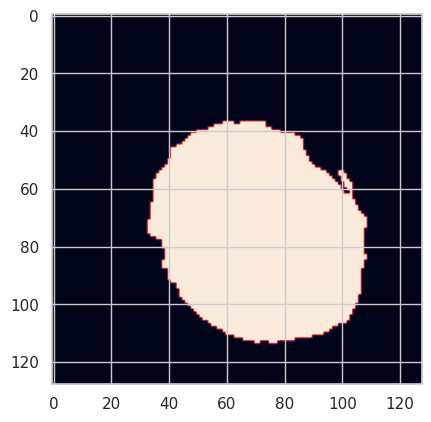

In [ ]:
plt.imshow(labelA[32])
plt.show()

plt.imshow(labelA[32])